# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import scipy as sp
import os
import glob
import sys
import pandas as pd
from datetime import datetime, timedelta
import collections
import matplotlib.cm as cm
#plt.rcdefaults() #Setting default color of output plots. No need in jupyter lab. Only for notebook with dark theme
# For interactive plots

#plt.rcParams.update({'figure.max_open_warning': 0})
#%matplotlib widget
#sys.path.insert(0, '/Home/siv30/wad005/useful_py_functions') #UiB
sys.path.insert(0, "/Users/andreas/proggis/useful_py_func/") #Mac
import matplotlib_custom_style_and_macros as pltmacro #Importin the py file from dir

# TODO:
   1) Redo all the plots ... export
   2) There might be some triggers in HED, where i havent extracted the LED file

# Paths

In [2]:
#path_HED = "/Home/siv30/wad005/master/GRB/MATLAB/output/file_mat_TGF/"              #UiB
#path_LED = "/Home/siv30/wad005/master/GRB/MATLAB/CZT_calibration/file_mat_CZT_TGF/" #UiB
path_HED = "/Users/andreas/phys/master/GRB/MATLAB/output/file_mat_TGF/"               #MAC
path_LED = "/Users/andreas/phys/master/GRB/MATLAB/CZT_calibration/file_mat_CZT_TGF/"  #MAC

# Dict creation

In [3]:
trig_dict_HED = {"GRB180720":["2018_07_20_14_21_48","2018_07_20_14_21_51","2018_07_20_14_21_56","2018_07_20_14_21_57","2018_07_20_14_22_09"],
                 "GRB180807":["2018_08_07_02_19_37"],
                 "GRB181103":["2018_11_03_04_22_33"],
                 "GRB181222":["2018_12_22_20_11_36"],
                 "GRB190117":["2019_01_17_08_50_43"],
                 "GRB190206":["2019_02_06_03_49_28"],
                 "GRB190305":["2019_03_05_13_05_19"],
                 "GRB190320":["2019_03_20_01_14_06"],
                 "GRB190404":["2019_04_04_07_01_05"],
                 "GRB190420":["2019_04_20_23_32_23"],
                 "GRB190501":["2019_05_01_05_23_22"],
                 "GRB190606":["2019_06_06_01_55_07"],
                 "GRB190615":["2019_06_15_14_42_21"],
                 "GRB190706":["2019_07_06_12_40_43"],
                 "GRB190813":["2019_08_13_12_00_49"],
                 "GRB190825":["2019_08_25_21_04_55","2019_08_25_21_04_53"], 
                 "GRB190829":["2019_08_29_19_56_40"],
                 "GRB190906":["2019_09_06_01_04_51"],
                 "GRB191001":["2019_10_01_06_41_52"],
                 "GRB191004":["2019_10_04_18_07_03"],
                 "GRB191119":["2019_11_19_10_41_06"],
                 "GRB191221":["2019_12_21_20_39_10","2019_12_21_20_39_11","2019_12_21_20_39_12","2019_12_21_20_39_13","2019_12_21_20_39_15"],
                 "GRB191227":["2019_12_27_17_21_45"], #Also triggered 5 seconds after. filname: "2019_12_27_17_21_49"
                 "GRB200111":["2020_01_11_15_11_12"],
                 "GRB200224":["2020_02_24_09_58_44"],
                 "GRB200415":["2020_04_15_08_48_05"],
                 "GRB200412":["2020_04_12_06_57_13", "2020_04_12_06_57_15", "2020_04_12_06_57_16", "2020_04_12_06_57_17", "2020_04_12_06_57_18", "2020_04_12_06_57_20",
                             "2020_04_12_06_57_21", "2020_04_12_06_57_22", "2020_04_12_06_57_23", "2020_04_12_06_57_24", "2020_04_12_06_57_25"] ,# long grb
                 "GRB200423":["2020_04_23_13_54_06"],
                 "GRB200521":["2020_05_21_12_16_39"],
                 "GRB200525":["2020_05_25_14_40_22"],
                 "GRB200605":["2020_06_05_18_17_42"],
                 "GRB200716":["2020_07_16_22_57_40"],
                 "GRB200812":["2020_08_12_11_55_23","2020_08_12_11_55_25"],
                 "GRB200925":["2020_09_25_21_50_31"],
                 "GRB200907":["2020_09_07_18_51_20"],
                 "GRB200915":["2020_09_15_03_27_06"],
                 "GRB200923":["2020_09_23_17_57_41"],
                 "GRB200925":["2020_09_25_21_50_31"],
                 "GRB201223":["2020_12_23_17_58_10"],
                 "GRB210102":["2021_01_02_20_38_02","2021_01_02_20_38_07"],
                 "GRB210411":["2021_04_11_13_32_30"],
                 "GRB210424":["2021_04_24_08_01_55"],
                 "GRB210607":["2021_06_07_21_39_20","2021_06_07_21_39_21","2021_06_07_21_39_22"],
                 "GRB210619":["2021_06_19_23_59_24","2021_06_19_23_59_25", "2021_06_19_23_59_26","2021_06_19_23_59_27", "2021_06_19_23_59_33", "2021_06_19_23_59_34",
                             "2021_06_19_23_59_35", "2021_06_19_23_59_36", "2021_06_19_23_59_37","2021_06_19_23_59_38"],
                 "GRB210701":['2021_07_01_20_01_00'],
                 "GRB210702":['2021_07_02_19_07_09','2021_07_02_19_07_10','2021_07_02_19_07_12'],
                 "GRB210724":["2021_07_24_20_14_03"],
                 "GRB201109":["2020_11_09_02_31_08"],
                 "GRB210903":["2021_09_03_17_26_58"],
                 "GRB211118":["2021_11_18_23_38_04"],
                 "GRB211211":["2021_12_11_13_10_01","2021_12_11_13_10_02","2021_12_11_13_10_05","2021_12_11_13_10_06","2021_12_11_13_10_15","2021_12_11_13_10_17",
                              "2021_12_11_13_10_18","2021_12_11_13_10_19"],
                 "GRB201227":['2020_12_27_15_14_06']
                 }
trig_dict_HED = collections.OrderedDict(sorted(trig_dict_HED.items())) #Sorting the keys in decending order. Now trig_dict_HED is an OderedDict type

for key in trig_dict_HED.keys():
    trig_dict_HED[key].sort() #sorting files in increasing order

In [4]:
trig_dict_LED = {"GRB181227":["2018.12.27_06.17.04.210500_Fulltrigger","2018_12_27_06_17_09.775992_Fulltrigger","2018_12_27_06_17_10.800851_Fulltrigger"],
                 "GRB181103":["2018.11.03_04.22.34.566125_Fulltrigger"],
                 "GRB190117":["2019.01.17_08.50.42.939689_Fulltrigger"],
                 "GRB190404":['2019.04.04_07.01.06.584820_Fulltrigger'],
                 "GRB190420":["2019.04.20_23.32.24.931211_Fulltrigger"],
                 "GRB190501":["2019.05.01_05.23.21.736797_Fulltrigger"],
                 "GRB190615":["2019.06.15_14.42.22.741579_Fulltrigger"],
                 "GRB190628":["2019.06.28_04.23.32.512290_Fulltrigger"],
                 "GRB190813":["2019.08.13_12.00.48.801260_Fulltrigger"],
                 "GRB190825":["2019.08.25_21.04.54.439617_Fulltrigger","2019.08.25_21.04.56.395859_Fulltrigger"],
                 "GRB190906":["2019.09.06_01.04.52.014004_Fulltrigger"],
                 "GRB191001":["2019.10.01_06.41.51.631214_Fulltrigger"],
                 "GRB191004":["2019.10.04_18.07.03.402478_Fulltrigger"],
                 "GRB191119":["2019.11.19_10.41.05.239944_Fulltrigger"],
                 "GRB191221":["2019.12.21_20.39.11.939846_Fulltrigger","2019.12.21_20.39.12.939997_Fulltrigger","2019.12.21_20.39.13.940233_Fulltrigger",
                              "2019.12.21_20.39.15.106045_Fulltrigger","2019.12.21_20.39.17.252498_Fulltrigger"],
                 "GRB191227":["2019.12.27_17.21.45.549390_Fulltrigger"], # Also triggered 5 sec after. filename: "2019.12.27_17.21.50.236046_Fulltrigger"
                 "GRB200111":["2020.01.11_15.11.13.187473_Fulltrigger"],
                 "GRB200122":["2020.01.22_05.18.10.228382_Fulltrigger"],
                 "GRB200224":["2020.02.24_09.58.44.448334_Fulltrigger"],
                 "GRB200412":["2020.04.12_06.57.15.879304_Fulltrigger", "2020.04.12_06.57.16.879531_Fulltrigger", "2020.04.12_06.57.17.879742_Fulltrigger",
                             "2020.04.12_06.57.18.880468_Fulltrigger"],
                 "GRB200415":["2020.04.15_08.48.05.470385_Fulltrigger"], #Giant magetar flare
                 "GRB200423":["2020.04.23_13.54.06.572991_Fulltrigger"],
                 "GRB200525":["2020.05.25_14.40.22.951437_Fulltrigger"],
                 "GRB200605":["2020.06.05_18.17.42.165859_Fulltrigger"],
                 "GRB200812":["2020.08.12_11.55.24.308429_Fulltrigger","2020.08.12_11.55.26.144703_Fulltrigger"],
                 "GRB200903":["2020.09.03_21.38.50.495317_Fulltrigger"],
                 "GRB200907":["2020.09.07_18.51.20.724118_Fulltrigger"],
                 "GRB200915":["2020.09.15_03.27.06.777086_Fulltrigger"],
                 "GRB200923":["2020.09.23_17.57.42.645020_Fulltrigger"],
                 "GRB201109":["2020.11.09_02.31.09.400868_Fulltrigger"],
                 "GRB210102":["2021.01.02_20.38.02.245585_Fulltrigger","2021.01.02_20.38.07.079069_Fulltrigger"],
                 "GRB210424":["2021.04.24_08.01.55.875520_Fulltrigger"],
                 "GRB210607":["2021.06.07_21.39.21.187641_Fulltrigger","2021.06.07_21.39.22.204550_Fulltrigger","2021.06.07_21.39.23.317169_Fulltrigger"],
                 
                }
trig_dict_LED = collections.OrderedDict(sorted(trig_dict_LED.items())) #Sorting the keys in decending order. Now trig_dict_HED is an OderedDict type

for key in trig_dict_LED.keys():
    trig_dict_LED[key].sort() #sorting files in increasing order

# Functions for handling matlab files

## CZT function

In [5]:
def read_matlab_file_with_CZT_data(filename):
    '''Read matlab file with ASIM CZT data from the low energy detector (LED)

    tus: relative time in microseconds (excluded multihits)
    erg: energy channel (excluded multihits)
    energy_keV: energy in keV (excluded multihits)
    tus_keep_multihit: relative time in microseconds (included multihits)
    erg_keep_multihit: energy channel (included multihits)
    multihit_indx: multihit index 0-4. 0->1 1->2// 0: tus=105, 1: tus=110,110 (two counts)
    '''
    mat = scipy.io.loadmat(path_LED + "%s.mat" % (filename))

    #keV_spectra = mat['keV_spectra_total_fulltrigger']

    # Included multihits. Important for light curves
    tus_keep_multihit = np.array(mat['tus_keep_multihit_fulltrigger'])[:,0] # relative time in microseconds
    erg_keep_multihit = np.array(mat['erg_keep_multihit_fulltrigger'])[0,:] # energy channel (unreliable for multi hits)
    multihit_indx = np.array(mat['multihit_fulltrigger'])[0,:] # multihit index. How many multihits in count. (0=1 count, 1=2 counts, 2=3 counts...)
    
    # The multihits are removed as they don't have a reliable energy estimate
    erg = np.array(mat['erg_fulltrigger'])[0,:] # energy channel of CZT pixel
    tus = np.array(mat['tus_fulltrigger'])[:,0] # relative time in microseconds
    energy_keV = np.array(mat['pixel_energy_fulltrigger']).flatten() # energy in keV of CZT pixel
    date = mat['T_ref_char'][0] #raw datetime as string
    
    #Logic that checks for array lengths
    try:
        length = len(tus_keep_multihit)
        if any(len(lst) != length for lst in [erg_keep_multihit, multihit_indx]):
        # at least one list has a different length
            raise ValueError("Arrays have different lengths")
            
        t_temp = []
        erg_temp = []
        energy_keV_temp = []
        
        for index, i in enumerate(multihit_indx):
            for j in np.arange(0,i+1): #adding i+1 times the tus_count
                t_temp.append(tus_keep_multihit[index])
                erg_temp.append(erg_keep_multihit[index])

         
        tus_keep_multihit_ntimes =  np.array(t_temp) #array of tus. Multihit index decides how many times the tus is appended
        erg_keep_multihit_ntimes = np.array(erg_temp) #array of erg. Multihit index decides how many times the erg is appended
        
        
        return tus, erg, energy_keV, tus_keep_multihit_ntimes, erg_keep_multihit_ntimes, multihit_indx, date 
    
    except ValueError as ve:
        print("Function aborted because of: " + str(ve))
        print("Length of arrays: ")
        for lst in [tus_keep_multihit, erg_keep_multihit, multihit_indx]:
            print(len(lst))

## BGO function

In [6]:
def read_matlab_file_with_BGO_data(matlabfilename):
    '''
    TODO: Keep original version
    
    Read matlab file with ASIM BGO data from the high energy detector (HED)

    tus: relative times in microseconds.
    erg: energy channel (needs to be calibrated to keV using calibration coeff from https://git.app.uib.no/ASIM-MXGS/IN-FLIGHT_CALIBRATION_BGO/-/tree/master/CALIBRATION_COEFS )
    typ: normal (0), fast(1), valley (3), or overflow event (2 or 4 not )
    adr: BGO address 1-12
    dau: dau address 1-4
    det: detector address 1-3
    DetCol: RGB color
    
    - Kepping only normal (0) and fast (1) events
    '''
    matlabfile_TGF = path_HED + '%s.mat' % matlabfilename
    
    mat = scipy.io.loadmat(matlabfile_TGF)
    
    tus = mat['tus'].flatten()
    erg = mat['erg'].flatten()
    adr = mat['adr'].flatten()
    dau = mat['dau'].flatten()
    det = mat['det'].flatten()
    typ = mat['typ'].flatten()
    
    date = mat['date'][0] #raw datetime
    
    
    try:
        length = len(tus)
        if any(len(lst) != length for lst in [erg, typ, adr, dau, det]):
        # at least one list has a different length
            raise ValueError("Arrays have different lengths")
            
        mask = np.where((typ != 0) & (typ != 1)) #finding indecies of vallays and overflow events
        
        # removing those indecies
        tus = np.delete(tus,mask)
        erg = np.delete(erg,mask)
        adr = np.delete(adr,mask)
        dau = np.delete(dau,mask)
        det = np.delete(det,mask)
        typ = np.delete(typ,mask)
        
        
        return tus, erg, typ, adr, dau, det, date
    
    except ValueError as ve:
        print("Function aborted because of: " + str(ve))
        print("Length of arrays: ")
        for lst in [tus,erg, typ, adr, dau, det]:
            print(len(lst))

In [7]:
#tus, erg, typ, adr, dau, det, date= read_matlab_file_with_BGO_data(trig_dict_HED["GRB190606"][0])
#print(date)

# Plotting functions

## LED

In [7]:
def plot_LED(grb_id=None, tus_arr = None, LED_filename=None, binsize=10, T0=None, export=False):
    """ Can switch between plotting by grb_id, tus_arr and LED_filename. Only one of the options at the time.
    plot_LED function can also find the background when start_range and end_range is specified"""
    
    binsize = binsize #ms
    
    
    #switch for input
    try:
        if LED_filename != None and grb_id == None and tus_arr == None:
            tus_LED, erg_LED, energy_keV_LED, tus_keep_multihit_LED, erg_keep_multihit_LED, multihit_indx_LED, date = read_matlab_file_with_CZT_data(
                LED_filename)
            T0 = datetime.strptime(date, "%Y-%b-%d %H:%M:%S.%f")
            date_id = datetime.strftime(T0,format='%y%m%d') #Correct format for title of plot: YYMMDD
            time_id = datetime.strftime(T0,format='%H:%M:%S.%f')[0:12] # T0 HHMMSS.f
            grb_id_title = "GRB " + date_id
            
        elif grb_id != None and tus_arr == None and LED_filename == None:
            if grb_id not in trig_dict_LED.keys():
                raise KeyError("GRB ID not in dict")
            else:
                LED_filename = trig_dict_LED[grb_id][0]
                tus_LED, erg_LED, energy_keV_LED, tus_keep_multihit_LED, erg_keep_multihit_LED, multihit_indx_LED, date = read_matlab_file_with_CZT_data(
                    LED_filename)
                T0 = datetime.strptime(date, "%Y-%b-%d %H:%M:%S.%f")
                date_id = datetime.strftime(T0,format='%y%m%d') #Correct format for title of plot: YYMMDD
                time_id = datetime.strftime(T0,format='%H:%M:%S.%f')[0:12] # T0 HHMMSS.f
                grb_id_title = "GRB " + date_id

        elif type(tus_arr) == np.ndarray and type(T0) == datetime and grb_id == None and LED_filename==None:
            tus_LED = tus_arr
            date_id = datetime.strftime(T0,format='%y%m%d') #Correct format for title of plot: YYMMDD
            time_id = datetime.strftime(T0,format='%H:%M:%S.%f')[0:12] # T0 HHMMSS.f
            grb_id_title = "GRB " + date_id
        else:
            return "T0 <datetime> must be specified when initiating tus_arr"
        
    except KeyError as e:
        return print(e)
    
    #Plotting routine for normal histograms. Adding output path
    plt.hist(tus_LED/1e3, bins=np.arange(
        min(tus_LED/1e3), max(tus_LED/1e3) + binsize, binsize), edgecolor= "black", histtype="step")
    plt.xlabel("time [ms], binsize {} ms".format((binsize)))
    plt.ylabel("Counts per bin"),
    plt.title(grb_id_title + " , " + "T0 = " + time_id)
     
    if export == True:
        path = "/Home/siv30/wad005/master/GRB/pyplots/LED/" #EXPORT PATH
        filename = path + grb_id_title
        plt.savefig(filename)
        plt.clf()
    else:
        plt.show()

## HED

In [8]:
def plot_HED(grb_id=None, tus_arr = None, HED_filename = None, binsize=10, T0=None, export=False):
    
    """Plotting data from HED. If HED_filename is not specified, but tus_arr is: plotting the tus array without reading matlab file
        If start and end value for the GRB is not given, the data is plotted normally,
        - BINSIZE IS INITIALIZED AS MILLISECONDS
        - start_GRB & end_GRB IS INITIALIZED AS MILLISECONDS 0.5 s = 500 ms
        - tus_HED is given in microseconds
        -T0 is given as a string
        -cut_idx: array of indecies that was used to cut the tus_arr
        -export: boolean. Exported to local dir.
    """

    binsize = binsize #ms
    

    # //TODO:
    #Create switch for plotting histograms with different color for showing the tus range plotted
    #Create switch if concat in needed
    
    #switch for input
    try:
        if HED_filename != None and grb_id == None and tus_arr == None:

            tus_HED, erg_HED, typ_HED, adr_HED, dau_HED, det_HED, date = read_matlab_file_with_BGO_data(HED_filename)
            T0 = datetime.strptime(date, "%Y-%b-%d %H:%M:%S.%f")
            date_id = datetime.strftime(T0,format='%y%m%d') #Correct format for title of plot: GRBYYMMDD
            time_id = datetime.strftime(T0,format='%H:%M:%S.%f')[0:12]
            grb_id_title = "GRB " + date_id
            
        elif grb_id != None and tus_arr == None and HED_filename == None:
            
            if grb_id not in trig_dict_HED.keys():
                raise KeyError("GRB ID not in dict")
            else:
                HED_filename = trig_dict_HED[grb_id][0]
                print("Plotting first HED file ...")
                
                tus_HED, erg_HED, typ_HED, adr_HED, dau_HED, det_HED, date = read_matlab_file_with_BGO_data(HED_filename)
                T0 = datetime.strptime(date, "%Y-%b-%d %H:%M:%S.%f")
                date_id = datetime.strftime(T0,format='%y%m%d') #Correct format for title of plot: GRBYYMMDD
                time_id = datetime.strftime(T0,format='%H:%M:%S.%f')[0:12] # T0 HHMMSS.f
                grb_id_title = "GRB " + date_id

        elif type(tus_arr) == np.ndarray and type(T0) == datetime and grb_id == None and HED_filename==None:
            
            print("Plotting tus array ...")
            tus_HED = tus_arr
            date_id = datetime.strftime(T0,format='%y%m%d') #Correct format for title of plot: YYMMDD
            time_id = datetime.strftime(T0,format='%H:%M:%S.%f')[0:12] # T0 HHMMSS.f
            grb_id_title = "GRB " + date_id
            
        else:
            return "Input not in right format"
        
    except KeyError as e:
        return print(e)
    
    
    #Plotting routine for normal histograms. Adding output path
    plt.hist(tus_HED/1e3, bins=np.arange(
            min(tus_HED/1e3), max(tus_HED/1e3) + binsize, binsize),edgecolor= "black", histtype="step")

    plt.xlabel("time [ms], binsize = {} ms".format((binsize)))
    plt.ylabel("Counts per bin"),
    plt.title(grb_id_title + " , " + "T0 = " + time_id)

    if export == True:
        path = "/Home/siv30/wad005/master/GRB/pyplots/HED/" #EXPORT PATH
        filename = path + grb_id_title
        plt.savefig(filename)
        plt.clf()
    else:
        plt.show()

# Concatination of multiple files

## Cutting index functions

In [9]:
def kit_kat(test,cut_idx):
    """ Test func"""
    out = []
    for i,idx in enumerate(cut_idx):
        if i==0:
            if idx != None:
                out.append(test[i][0:idx])
            else:
                out.append(test[i])
        elif  i == len(test)-2:
            out.append(test[i])
        else:
            if idx != None:
                out.append(test[i][:idx])
            else:
                out.append(test[i])
                
    return np.concatenate(out)

In [10]:
# A better algo for finding the cut idx 
def find_subsequence(seq, subseq):
    
    """This function find the indecies where the subseq begins
    Will return an array of starting positions"""
    
    target = np.dot(subseq, subseq)
    candidates = np.where(np.correlate(seq,subseq, mode='valid') == target)[0]
    # some of the candidates entries may be false positives, double check
    check = candidates[:, np.newaxis] + np.arange(len(subseq))
    mask = np.all((np.take(seq, check) == subseq), axis=-1)
    
    if len(candidates[mask]) > 1:
        print("found two candidates for cutting ... selecting the first")
        return candidates[mask][0]
    elif len(candidates[mask]) == 0:
        print("subseq not found in next array ... keeping whole array")
        return None
    else:
        print("found one cutting index ... ")
        return candidates[mask][0]

In [11]:
first = np.array([1,2,3,4,5,6,7])
second = np.array([6,7,8,9,10])
third = np.array([8,9,10,11,12,13,14])
fourth = np.array([11,12,13,14,15,16])

test = [first,second,third,fourth]

first_i = find_subsequence(first,second[0:2])
second_i = find_subsequence(second,third[0:2])
third_i = find_subsequence(third,fourth[0:2])

print(first[0:first_i],"starts at 0, cutting index: ", first_i)
print(second[:second_i],"cutting index: ", second_i)
print(third[:third_i],"cutting index: ", third_i)
print(fourth)

found one cutting index ... 
found one cutting index ... 
found one cutting index ... 
[1 2 3 4 5] starts at 0, cutting index:  5
[6 7] cutting index:  2
[ 8  9 10] cutting index:  3
[11 12 13 14 15 16]


In [154]:
#Comments: This straight forward method did not work
#Trying new approach: searching for the nearest tus match, and searching region around that. Might be good for first approximation.
# How to do it? 
#       Since 1 second of data is added to each consecutive file:
#       Find the closest match for the last tus in the next array.

In [12]:
def find_nearest(array, value):
    """Returns nearest index for value in array.
    """
    array = np.asarray(array)
    return (np.abs(array - value)).argmin()

Plotting tus array ...


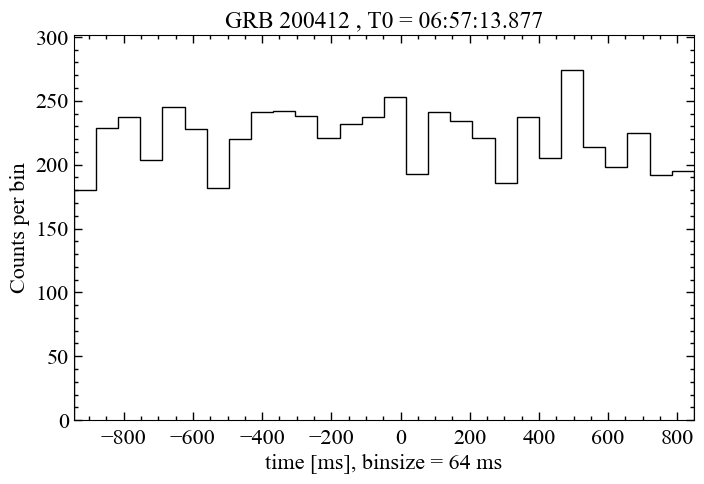

NameError: name 'search' is not defined

In [20]:
for i,tus in enumerate(tus_master_test):
    if i == 0:
        plot_HED(tus_arr=tus,T0=T_master_test[0],binsize=64)
    else:
        print(search[i])
        plot_HED(tus_arr=tus,T0=T_master_test[0],binsize=64)

In [128]:
#Wrong in this function: keeping all the previous
def cut_list(arr_list,offset):
    """This function find the cut for the next array. The previous array will be -50 elements short IF an overlap is found"""
    idxs = []
    i = 0
    while i+1 <= len(arr_list)-1:
        cut_idx = find_subsequence(arr_list[i], arr_list[i+1][0:offset])
        idxs.append(cut_idx)
        i += 1
    return idxs

In [12]:
def cut_cat(tus_master,erg_master, cut_list):
    """Need to check if the next array is bigger. special case"""
    
    tus_cut = []
    erg_cut = []
    
    for i in np.arange(0,len(tus_master)): #only i-1 elements in cut_list
        if i == 0:
            if cut_list[i] == None:
                tus_cut.append(tus_master[i])
                erg_cut.append(erg_master[i])
            else:
                print("i: ", i)
                print("tus 0. upper: ", tus_master[i][-50]/1e3)
                
                tus_cut.append(tus_master[i][0:-50])
                #tus_cut.append(tus_master[i+1][0:cut_list[i]])
                
                erg_cut.append(erg_master[i][0:-50])
                #erg_cut.append(erg_master[i+1][0:cut_list[i]])
                
        elif i == 1:
            if cut_list[i-1] == None:
                tus_cut.append(tus_master[i])
            else:
                tus_cut.append(tus_master[i][:cut_list[i-1]])
                print("tus 1. lower, ", tus_master[i][0]/1e3)
                print("tus 1. upper: ",tus_master[i][cut_list[i-1]]/1e3)
                
                
    
        elif i == len(tus_master)-1:
            if cut_list[i-1] == None:
                print("appending whole last array")
                tus_cut.append(tus_master[i])
            else:
                print("No cutting of last array")
            
            
            
        else:
            if cut_list[i-1] == None:
                print("i: ", i)
                print("whole arr from: ", tus_master[i][0]/1e3)
                tus_cut.append(tus_master[i])
                #erg_cut.append(erg_master[i])
                
            else:
                print("i: ", i)
                print("tus start: ", tus_master[i][cut_list[i-2]]/1e3)
                print("tus end: ", tus_master[i][cut_list[i-1]]/1e3)
                tus_cut.append(tus_master[i][cut_list[i-2]:cut_list[i-1]])
                #erg_cut.append(erg_master[i][cut_list[i-2]:cut_list[i-1]])
    tus_cut_cat = np.concatenate(tus_cut)
    erg_cut_cat = np.concatenate(erg_cut)
    
    return tus_cut_cat,erg_cut_cat

## Debugging concat function

In [13]:
def cat(grb_id,flag):
    tus_list = []
    erg_list = []
    T = []
    deltas = []
    tus_master = []
    erg_master = []
    tus_shift_list = []
    
    
    if flag == "HED":
        HED_files = trig_dict_HED[grb_id]
        
        for filename in HED_files:
            tus, erg, typ, adr, dau, det, date = read_matlab_file_with_BGO_data(filename)
            tus_list.append(tus)
            erg_list.append(erg)
            T.append(datetime.strptime(date, "%Y-%b-%d %H:%M:%S.%f"))
    else:
        LED_files = trig_dict_LED[grb_id]
        
        for filename in LED_files:
            tus, erg, energy_keV, tus_keep_multihit_ntimes, erg_keep_multihit_ntimes, multihit_indx, date = read_matlab_file_with_CZT_data(filename)
            tus_list.append(tus)
            erg_list.append(erg)
            T.append(datetime.strptime(date, "%Y-%b-%d %H:%M:%S.%f"))
        
    T0 = T[0]
    
    for i,TT in enumerate(T):
        if i == 0:
            delta = 0
            index_sort = np.argsort(tus_list[i], kind="mergesort")
            tus_sort = tus_list[i][index_sort]
            erg_sort = erg_list[i][index_sort]
            tus_master.append(tus_sort)
            erg_master.append(erg_sort)
            
        else:
            delta = TT-T0
            tus_shift = tus_list[i] + float(delta.total_seconds())*1e6
            index_sort = np.argsort(tus_shift, kind="mergesort")
            tus_sort = tus_shift[index_sort]
            erg_sort = erg_list[i][index_sort]
            
            tus_master.append(tus_sort)
            erg_master.append(erg_sort)
            
    idxs = cut_list(erg_master)
    tus_cat, ergs_cat = cut_cat(tus_master, erg_master, idxs)
    print(type(tus_cat))

    #By this point, the tus_master matches first and last element in tus_master_test
            
    return tus_cat, ergs_cat, T

In [14]:
#TODO: Work around the fact that the arrays contain pieces of the n previous arrays

In [15]:
# importing arrays
tus1, erg1, typ1, adr1, dau1, det1, date1 = read_matlab_file_with_BGO_data(trig_dict_HED["GRB200412"][0])
tus2, erg2, typ2, adr2, dau2, det2, date2 = read_matlab_file_with_BGO_data(trig_dict_HED["GRB200412"][1])
tus3, erg3, typ3, adr3, dau3, det3, date3 = read_matlab_file_with_BGO_data(trig_dict_HED["GRB200412"][2])
tus4, erg4, typ4, adr4, dau4, det4, date4 = read_matlab_file_with_BGO_data(trig_dict_HED["GRB200412"][3])
tus5, erg5, typ5, adr5, dau5, det5, date5 = read_matlab_file_with_BGO_data(trig_dict_HED["GRB200412"][4])
tus6, erg6, typ6, adr6, dau6, det6, date6 = read_matlab_file_with_BGO_data(trig_dict_HED["GRB200412"][5])

In [16]:
#T
T1 = datetime.strptime(date1, "%Y-%b-%d %H:%M:%S.%f") #T0 of first file. Will be T0 for concat tus array
T2 = datetime.strptime(date2, "%Y-%b-%d %H:%M:%S.%f")
T3 = datetime.strptime(date3, "%Y-%b-%d %H:%M:%S.%f")
T4 = datetime.strptime(date4, "%Y-%b-%d %H:%M:%S.%f")
T5 = datetime.strptime(date5, "%Y-%b-%d %H:%M:%S.%f")
T6 = datetime.strptime(date6, "%Y-%b-%d %H:%M:%S.%f")


#Adding the timeshift to all tus arrays from T0
deltaT2 = T2 - T1
deltaT3 = T3- T1
deltaT4 = T4 - T1
deltaT5 = T5- T1
deltaT6 = T6 - T1

tus2_shift = tus2 + float(deltaT2.total_seconds())*1e6 #deltaT to all entries from T1
tus3_shift = tus3 + float(deltaT3.total_seconds())*1e6
tus4_shift = tus4 + float(deltaT4.total_seconds())*1e6
tus5_shift = tus5 + float(deltaT5.total_seconds())*1e6
tus6_shift = tus6 + float(deltaT6.total_seconds())*1e6

In [17]:
#Sorting the arrays
index_sort1 = np.argsort(tus1, kind="mergesort")
tus1_sort = tus1[index_sort1]
erg1_sort = erg1[index_sort1]

index_sort2 = np.argsort(tus2_shift, kind="mergesort")
tus2_sort = tus2_shift[index_sort2]
erg2_sort = erg2[index_sort2]

index_sort3 = np.argsort(tus3_shift, kind="mergesort")
tus3_sort = tus3_shift[index_sort3]
erg3_sort = erg3[index_sort3]

index_sort4 = np.argsort(tus4_shift, kind="mergesort")
tus4_sort = tus4_shift[index_sort4]
erg4_sort = erg4[index_sort4]

index_sort5 = np.argsort(tus5_shift, kind="mergesort")
tus5_sort = tus5_shift[index_sort5]
erg5_sort = erg5[index_sort5]

index_sort6 = np.argsort(tus6_shift, kind="mergesort")
tus6_sort = tus6_shift[index_sort6]
erg6_sort = erg6[index_sort6]

In [18]:
tus_master_test = [tus1, tus2_shift, tus3_shift, tus4_shift, tus5_shift, tus6_shift]
erg_master_test = [erg1,erg2,erg3,erg4,erg5,erg6]
T_master_test = [T1,T2,T3,T4,T5,T6]

### Debugg cont.

### Manual cut

In [16]:
def lower_upper_bound(l):
    for tus in l:
        print("min: ", round(min(tus/1e3)),"max: ",round(max(tus)/1e3))

## Cropping pdf

## Function for exporting all light curves

In [20]:
# export path to folder:
path_out_HED = '/Users/andreas/phys/master/GRB/pyplots/HED/'
path_out_LED = '/Users/andreas/phys/master/GRB/pyplots/LED/'

In [21]:
def export_plots(path_LED=None,path_HED=None):
    """Function for exporting and cropping pdfs"""
    
    
    for grb_id in trig_dict_HED.keys():
        if len(trig_dict_HED[grb_id]) <= 1:
               plot_HED(grb_id=grb_id ,binsize = 16, export=True)
        else:
            concat_tus_HED, concat_erg_HED, T0 = concat_GRB(grb_id= grb_id, flag="HED")
            plot_HED(tus_arr= concat_tus_HED,T0= T0, binsize=32, export=True)
               
    for grb_id in trig_dict_LED.keys():
        if len(trig_dict_LED[grb_id]) <= 1:
               plot_LED(grb_id=grb_id ,binsize = 16, export=True)
        else:
            concat_tus_LED, concat_erg_LED, T0 = concat_GRB(grb_id=grb_id,flag="LED")
            plot_LED(tus_arr = concat_tus_LED, binsize=32, T0 = T0, export=True)
            
    print("Cropping LED plots from path ...")
    crop_pdfs(path_LED)
    
    print("Cropping HED plots from path ...")
    crop_pdfs(path_HED)
    
    print("Done")
    return None

In [19]:
def crop_pdfs(path):
    for f in os.listdir(path):
        command = "pdfcrop --margins " + '"1 1 1 1"' + " " + '"%s%s"' % (path,f) + " " + '"%s%s"' % (path,f)
        os.system(command)
    return None

# main function

In [22]:
# On hold for now. 
"""def main(grb_id,binsize=10000, start_GRB, end_GRB):  # filename GRB ID
    # output array for tus_keep_multihit_LED, erg_keep_multihit_LED, multihit_indx_LED må modifiseres
    # Automake by making filename a list of filenames. Then the all the outout plots will be created

    # TODO:
    # Add the extra parameters to make the get_mean work
#os.mkdir("/Users/andreas/phys/master/MATLAB/pyplots")
    trig_dict = create_triggers_dict()
    try:
        output_dir = os.mkdir("/Home/siv30/wad005/master/GRB/MATLAB/pyplots/{}".format(grb_id)) #Creating owd folder for grb_id
    except FileExistsError:
        output_dir = "/Home/siv30/wad005//master/GRB/MATLAB/pyplots/{}".format(grb_id) #selecting path if it already exists


    if type(grb_id) != str:
        raise TypeError("Input is not string")
    elif grb_id not in trig_dict:
        raise LookupError("grb_id not in dictionary")
    else:
        try:
            LED_filename = trig_dict[grb_id][0]
            HED_filename = trig_dict[grb_id][1]
            if type(LED_filename) == float and math.isnan(LED_filename):
                print("LED file not found. Plotting only HED")
                plot_HED(HED_filename,output_dir,grb_id) #output path is not required
                
            elif type(HED_filename) == float and math.isnan(HED_filename):
                print("HED file not found. Plotting only LED")
                plot_LED(LED_filename,output_dir,grb_id)
            else:
                plot_LED(LED_filename,output_dir,grb_id)
                plot_HED(HED_filename,output_dir,grb_id)
        except:
            print("Something went wrong")
    """
    

'def main(grb_id,binsize=10000, start_GRB, end_GRB):  # filename GRB ID\n    # output array for tus_keep_multihit_LED, erg_keep_multihit_LED, multihit_indx_LED må modifiseres\n    # Automake by making filename a list of filenames. Then the all the outout plots will be created\n\n    # TODO:\n    # Add the extra parameters to make the get_mean work\n#os.mkdir("/Users/andreas/phys/master/MATLAB/pyplots")\n    trig_dict = create_triggers_dict()\n    try:\n        output_dir = os.mkdir("/Home/siv30/wad005/master/GRB/MATLAB/pyplots/{}".format(grb_id)) #Creating owd folder for grb_id\n    except FileExistsError:\n        output_dir = "/Home/siv30/wad005//master/GRB/MATLAB/pyplots/{}".format(grb_id) #selecting path if it already exists\n\n\n    if type(grb_id) != str:\n        raise TypeError("Input is not string")\n    elif grb_id not in trig_dict:\n        raise LookupError("grb_id not in dictionary")\n    else:\n        try:\n            LED_filename = trig_dict[grb_id][0]\n            HED

#LED concatination ----------------------------------------------
        elif flag == "LED":
            data = []
            num_files = len(LED_files)
                
            for filename in LED_files:
                
                #Working only with 
                tus, erg, energy_keV, tus_keep_multihit_ntimes, erg_keep_multihit_ntimes, multihit_indx, date = read_matlab_file_with_CZT_data(filename)
                if len(date) != 27:
                    raise ValueError("ValueError: Length of datetime string is not in correct format")
                    
                else:
                    index_sort = np.argsort(tus_keep_multihit_ntimes, kind="mergesort") # sorting tus in increasing order. Mergesort will not be affected by floating point error

                    tus_sort, erg_sort = tus_keep_multihit_ntimes[index_sort], erg_keep_multihit_ntimes[index_sort] #Making sure that the are coherent

                    file_dict = {"tus":tus_sort, "erg":erg_sort, "date":date}

                    data.append(file_dict)
            
            T0 = datetime.strptime(data[0]["date"], "%Y-%b-%d %H:%M:%S.%f") #T0 of first file. Will be T0 for concat tus array

            # Adding the timeshift to all tus arrays from T0
            for i in np.arange(1,num_files):
                deltaT = datetime.strptime(data[i]["date"], "%Y-%b-%d %H:%M:%S.%f") - T0
                data[i]["tus"] = data[i]["tus"] + float(deltaT.total_seconds())*1e6 #deltaT to all entries from T0


            # Cutting arrays at respective index; idx
            i = 0
            while i < num_files-1: #Need num_files-1 cutting indecies

                idx = find_cut_idx(tus1=data[i]["tus"], tus2=data[i+1]["tus"], erg1= data[i]["erg"] , erg2 = data[i+1]["erg"], index_file= i) #index for cutting     
                data[i]["tus"] = data[i]["tus"][:idx] #cutting arrays at idx
                data[i]["erg"] = data[i]["erg"][:idx]  #cutting arrays at idx
                
                i += 1

            #Concatenating respective arrays
            concat_tus_LED = np.concatenate([data[i]["tus"] for i in range(0,num_files)]) #concatinating tus arrays 
            concat_erg_LED = np.concatenate([data[i]["erg"] for i in range(0,num_files)])

            
            
            # //TODO: return the cutting indecies
            return concat_tus_LED, concat_erg_LED, T0
        
        else:
            print("No flag of type of GRB provided")

# Purgatory

### Setup for debugging the find_cut_idx:



tus1, erg1, typ1, adr1, dau1, det1, DetCol1, date1 = read_matlab_file_with_BGO_data(trig_dict_HED["GRB200412"][1])
tus2, erg2, typ2, adr2, dau2, det2, DetCol2, date2 = read_matlab_file_with_BGO_data(trig_dict_HED["GRB200412"][2])

T0 = datetime.strptime(date1, "%Y-%b-%d %H:%M:%S.%f") #T0 of first file. Will be T0 for concat tus array

Adding the timeshift to all tus arrays from T0

deltaT = datetime.strptime(date2, "%Y-%b-%d %H:%M:%S.%f") - T0
tus2_shift = tus2 + float(deltaT.total_seconds())*1e6 #deltaT to all entries from T0

index_sort1 = np.argsort(tus1, kind="mergesort")
tus1_sort = tus1[index_sort1]
erg1_sort = erg1[index_sort1]

index_sort2 = np.argsort(tus2_shift, kind="mergesort")
tus2_sort = tus2_shift[index_sort2]
erg2_sort = erg2[index_sort2]


### Cut idx plot    
    if cut_idx != None: #plotting a specified range of the histogram in a color
        colors = cm.rainbow(np.linspace(0, 1, len(cut_idx)))
        
        fig0, ax1 = plt.subplots(
        1, 1, figsize=fig, sharex=True, sharey=False)
        
        for idx, c in zip(cut_idx, colors):
            ax1.hist(tus_HED, bins=np.arange(min(tus_HED), 
                                             max(tus_HED) + binsize, binsize),edgecolor= "black", histtype="step")
        
        
        

    if start_GRB and end_GRB != 0:
        mean = get_mean(HED_filename,binsize,tus_HED, start_GRB, end_GRB)
        ax1.axhline(y=mean, color="red", label= "Mean of bg: {} counts/bin \n First range [{} - {}] s \n 2nd: [{} - {}] s".format(
            np.round(mean,2), np.round(min(tus_HED)/1e6,3),start_GRB/1e6, end_GRB/1e6, np.round(max(tus_HED)/1e6,3)),linestyle='--'),
        ax1.legend()
        plt.show(),
    else:
        plt.show()

### Rename start_GRB to start_range. Same for end_GRB
def get_mean(matlab_filename, binsize, tus, start_GRB, end_GRB):
    
    """Function for getting the mean from the background.
    matlab_filename: <str> filename
    binsize: <int> given in us // 5ms = 5000 us 
    start & end_GRB given in us.
    -Finding ranges to compute the mean in each bin. """
    
    tus = np.sort(tus)
    range_1 =  find_closest(tus,start_GRB)
    range_2 = find_closest(tus,end_GRB)
    
    range_1_counts = np.histogram(tus[:range_1], bins=np.arange(
        min(tus[:range_1]), max(tus[:range_1]) + binsize, binsize))[0]
    
    range_2_counts = np.histogram(tus[range_2:], bins=np.arange(
        min(tus[range_2:]), max(tus[range_2:]) + binsize, binsize))[0]
    
    background_data = np.append(range_1_counts,range_2_counts)
    mean = np.mean(background_data)
    return mean